In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:

import os
import shutil


os.makedirs("/root/.kaggle", exist_ok=True)


shutil.copy("/content/drive/MyDrive/SkinCancerEnvironment/.kaggle/kaggle.json", "/root/.kaggle/")


os.chmod("/root/.kaggle/kaggle.json", 600)


In [3]:
!pip install -q kaggle


!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000


Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
License(s): CC-BY-NC-SA-4.0
100% 5.18G/5.20G [02:00<00:00, 40.4MB/s]
100% 5.20G/5.20G [02:03<00:00, 45.2MB/s]


In [4]:
import zipfile

with zipfile.ZipFile("skin-cancer-mnist-ham10000.zip", "r") as zip_ref:
    zip_ref.extractall("HAM10000")


In [5]:
import pandas as pd
import numpy as np
import os
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [76]:
import pandas as pd
import os
from PIL import Image
from sklearn.utils import shuffle
import numpy as np


metadata_path = "HAM10000/HAM10000_metadata.csv"
df = pd.read_csv(metadata_path)


def get_image_path(image_id):
    path1 = f"HAM10000/HAM10000_images_part_1/{image_id}.jpg"
    path2 = f"HAM10000/HAM10000_images_part_2/{image_id}.jpg"
    return path1 if os.path.exists(path1) else path2

df['path'] = df['image_id'].map(get_image_path)


def is_valid_image(path):
    try:
        img = Image.open(path)
        img.verify()
        return True
    except:
        return False

df = df[df['path'].apply(is_valid_image)].reset_index(drop=True)


train_per_class = 300
val_per_class = 20

balanced_train = []
balanced_val = []

for label in df['dx'].unique():
    class_subset = df[df['dx'] == label]
    class_subset = shuffle(class_subset, random_state=42)


    available_samples = len(class_subset)
    train_count = min(train_per_class, available_samples - val_per_class)

    train_data = class_subset.iloc[:train_count]
    val_data = class_subset.iloc[train_count:train_count + val_per_class]

    balanced_train.append(train_data)
    balanced_val.append(val_data)

train_df_bal = pd.concat(balanced_train).reset_index(drop=True)
val_df_bal = pd.concat(balanced_val).reset_index(drop=True)

print(f"Balanced training set size: {len(train_df_bal)}")
print(f"Balanced validation set size: {len(val_df_bal)}")
print("\nTrain class distribution:\n", train_df_bal['dx'].value_counts())
print("\nVal class distribution:\n", val_df_bal['dx'].value_counts())

class_names = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc', 'mel']
label_to_index = {label: idx for idx, label in enumerate(class_names)}


train_df_bal['label'] = train_df_bal['dx'].map(label_to_index)
val_df_bal['label'] = val_df_bal['dx'].map(label_to_index)

print("Train class distribution:\n", train_df_bal['label'].value_counts(sort=False))
print("Val class distribution:\n", val_df_bal['label'].value_counts(sort=False))
print("Class index mapping:", label_to_index)

Balanced training set size: 1717
Balanced validation set size: 140

Train class distribution:
 dx
bkl      300
nv       300
mel      300
akiec    300
bcc      300
vasc     122
df        95
Name: count, dtype: int64

Val class distribution:
 dx
bkl      20
nv       20
df       20
mel      20
vasc     20
bcc      20
akiec    20
Name: count, dtype: int64
Train class distribution:
 label
2    300
4    300
3     95
6    300
5    122
1    300
0    300
Name: count, dtype: int64
Val class distribution:
 label
2    20
4    20
3    20
6    20
5    20
1    20
0    20
Name: count, dtype: int64
Class index mapping: {'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'nv': 4, 'vasc': 5, 'mel': 6}


In [78]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.utils import shuffle
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers


class_names = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc', 'mel']
label_to_index = {label: idx for idx, label in enumerate(class_names)}


train_df_bal['label'] = train_df_bal['dx'].map(label_to_index)
val_df_bal['label'] = val_df_bal['dx'].map(label_to_index)


IMG_SIZE = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df_bal,
    x_col='path',
    y_col='dx',
    target_size=IMG_SIZE,
    batch_size=batch_size,
    class_mode='categorical',
    classes=class_names,
    shuffle=True
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df_bal,
    x_col='path',
    y_col='dx',
    target_size=IMG_SIZE,
    batch_size=batch_size,
    class_mode='categorical',
    classes=class_names,
    shuffle=False
)

print("Train distribution:\n", train_df_bal['dx'].value_counts())
print("\nVal distribution:\n", val_df_bal['dx'].value_counts())

total_train = len(train_df_bal)
total_val = len(val_df_bal)

batch_size = 32

print(f"\nTraining samples: {total_train} | Steps per epoch: {np.ceil(total_train / batch_size)}")
print(f"Validation samples: {total_val} | Validation steps: {np.ceil(total_val / batch_size)}")

print("Class indices used by generator:", train_generator.class_indices)


class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array(class_names),
    y=train_df_bal['dx']
)


index_to_weight = {label_to_index[label]: weight for label, weight in zip(class_names, class_weights)}



num_classes = len(class_names)

model = Sequential([
    # First Convolutional Block
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3),
           kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', padding='same',
           kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.35),

    # Second Convolutional Block
    Conv2D(64, (3, 3), activation='relu', padding='same',
           kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same',
           kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.35),

    # Third Convolutional Block
    Conv2D(64, (3, 3), activation='relu', padding='same',
           kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same',
           kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.35),

    # Dense Layers
    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(0.6),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(0.6),
    Dense(num_classes, activation='softmax')
])


model.compile(
    optimizer=Adam(learning_rate=5e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=2,
    min_lr=1e-6
)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    class_weight=index_to_weight,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)


model.save("custom_cnn_skin_model_v2.h5")
print("Model saved as custom_cnn_skin_model_v2.h5")


train_loss, train_acc = model.evaluate(train_generator)
val_loss, val_acc = model.evaluate(val_generator)
print(f"Training Accuracy: {train_acc:.4f}, Training Loss: {train_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}, Validation Loss: {val_loss:.4f}")


Found 1717 validated image filenames belonging to 7 classes.
Found 140 validated image filenames belonging to 7 classes.
Train distribution:
 dx
bkl      300
nv       300
mel      300
akiec    300
bcc      300
vasc     122
df        95
Name: count, dtype: int64

Val distribution:
 dx
bkl      20
nv       20
df       20
mel      20
vasc     20
bcc      20
akiec    20
Name: count, dtype: int64

Training samples: 1717 | Steps per epoch: 54.0
Validation samples: 140 | Validation steps: 5.0
Class indices used by generator: {'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'nv': 4, 'vasc': 5, 'mel': 6}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 55s 762ms/step - accuracy: 0.1727 - loss: 12.9657 - val_accuracy: 0.1429 - val_loss: 13.4677 - learning_rate: 5.0000e-04
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 33s 605ms/step - accuracy: 0.2043 - loss: 12.4995 - val_accuracy: 0.1429 - val_loss: 11.5377 - learning_rate: 5.0000e-04
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 34s 618ms/step - accuracy: 0.2312 - loss: 11.7589 - val_accuracy: 0.1357 - val_loss: 11.2876 - learning_rate: 5.0000e-04
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 33s 603ms/step - accuracy: 0.2554 - loss: 10.8460 - val_accuracy: 0.1571 - val_loss: 10.1151 - learning_rate: 5.0000e-04
Epoch 5/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 34s 626ms/step - accuracy: 0.2940 - loss: 10.1201 - val_accuracy: 0.1500 - val_loss: 9.5364 - learning_rate: 5.0000e-04
Epoch 6/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 33s 603ms/step - accuracy: 0.2790 - loss: 9.4407 - val_accuracy: 0.2071 - val_loss: 9.0977 - learning_rate: 5.0000e-04
Epoch 7/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 41s 602ms/s

Model saved as custom_cnn_skin_model_v2.h5
54/54 ━━━━━━━━━━━━━━━━━━━━ 31s 581ms/step - accuracy: 0.3695 - loss: 6.1605
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step - accuracy: 0.4037 - loss: 6.1127
Training Accuracy: 0.3762, Training Loss: 6.1725
Validation Accuracy: 0.4143, Validation Loss: 6.1340


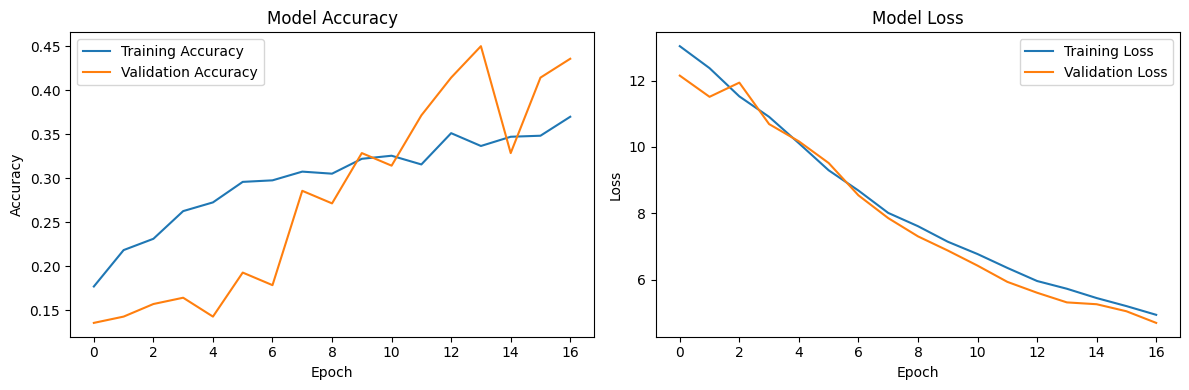

In [63]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [64]:
!ls

'akiec (1).jpg'   bkl.jpg		        mel.jpg
'akiec (2).jpg'   custom_cnn_skin_model_v2.h5  'nv (1).jpg'
'akiec (3).jpg'  'df (1).jpg'		       'nv (2).jpg'
 akiec.jpg	 'df (2).jpg'		        nv.jpg
'bcc (1).jpg'	 'df (3).jpg'		        sample_data
'bcc (2).jpg'	  df.jpg		        skin-cancer-mnist-ham10000.zip
'bcc (3).jpg'	  drive			        test_image.jpg
 bcc.jpg	  HAM10000		       'vasc (1).jpg'
'bkl (1).jpg'	  ISIC_0024306.jpg	       'vasc (2).jpg'
'bkl (2).jpg'	 'mel (1).jpg'		       'vasc (3).jpg'
'bkl (3).jpg'	 'mel (2).jpg'		        vasc.jpg
'bkl (4).jpg'	 'mel (3).jpg'


In [65]:
from tensorflow.keras.models import load_model
model = load_model("custom_cnn_skin_model_v2.h5")
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 56, 56, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 56, 56, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │    12,845,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 13,021,353 (49.67 MB)

 Trainable params: 13,019,943 (49.67 MB)

 Non-trainable params: 1,408 (5.50 KB)

 Optimizer params: 2 (12.00 B)

In [66]:
from google.colab import files
files.download("HAM10000/HAM10000_images_part_1/ISIC_0024306.jpg")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [19]:
from PIL import Image
img = Image.open("test_image.jpg")
print("Image mode:", img.mode)

Image mode: RGB


In [20]:
print(val_df_bal['dx'].unique())

['bkl' 'nv' 'df' 'mel' 'vasc' 'bcc' 'akiec']


Unique class labels in val_df_bal: ['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec']


Model loaded successfully.
Model output classes: 7
Please upload a test image (JPG/PNG, e.g., ISIC_0024306.jpg from HAM10000)


Saving ISIC_0024306.jpg to ISIC_0024306.jpg


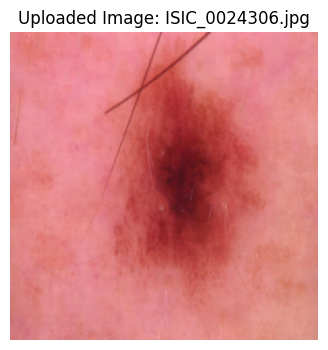

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

Prediction: nv
Probabilities:
  akiec: 0.0070
  bcc: 0.0007
  bkl: 0.0023
  df: 0.0086
  nv: 0.9779
  vasc: 0.0026
  mel: 0.0008


In [22]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from PIL import Image
import matplotlib.pyplot as plt
from google.colab import files
import os


class_names = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc', 'mel']


try:

    val_unique = list(val_df_bal['dx'].unique())
    print("Unique class labels in val_df_bal:", val_unique)
except NameError:
    print("val_df_bal not found, proceeding with canonical class_names.")


try:
    model = load_model("custom_cnn_skin_model_v2.h5")
    print("Model loaded successfully.")


    output_shape = model.layers[-1].output.shape[1]
    print(f"Model output classes: {output_shape}")
    if output_shape != len(class_names):
        print(f"Warning: Model expects {output_shape} classes, but class_names has {len(class_names)} classes.")
except Exception as e:
    print(f"Failed to load model: {e}")
    raise


print("Please upload a test image (JPG/PNG, e.g., ISIC_0024306.jpg from HAM10000)")
uploaded = files.upload()

for filename in uploaded.keys():
    if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
        try:

            img = Image.open(filename)
            if img.mode != 'RGB':
                img = img.convert('RGB')
            img = img.resize((224, 224))
            img_array = img_to_array(img) / 255.0
            img_array = np.expand_dims(img_array, axis=0)


            plt.figure(figsize=(4,4))
            plt.imshow(img)
            plt.title(f"Uploaded Image: {filename}")
            plt.axis('off')
            plt.show()


            predictions = model.predict(img_array)
            predicted_index = np.argmax(predictions[0])


            if predicted_index >= len(class_names):
                raise IndexError(f"Predicted index {predicted_index} exceeds class_names length {len(class_names)}")

            predicted_class = class_names[predicted_index]

            probabilities = {class_names[i]: float(predictions[0][i]) for i in range(len(class_names))}

            print("\nPrediction:", predicted_class)
            print("Probabilities:")
            for label, prob in probabilities.items():
                print(f"  {label}: {prob:.4f}")

        except Exception as e:
            print(f"Error processing image {filename}: {e}")
        break
    else:
        print(f"Skipping {filename}: Not a JPG/PNG file")

In [23]:
import pandas as pd

metadata_path = "HAM10000/HAM10000_metadata.csv"
df = pd.read_csv(metadata_path)


image_id = "ISIC_0024306"
label = df[df['image_id'] == image_id]['dx'].values
if len(label) > 0:
    print(f"Class label for {image_id}: {label[0]}")
else:
    print(f"Image {image_id} not found in metadata.")


import os
path1 = f"HAM10000/HAM10000_images_part_1/{image_id}.jpg"
path2 = f"HAM10000/HAM10000_images_part_2/{image_id}.jpg"
if os.path.exists(path1):
    print(f"Image found at: {path1}")
elif os.path.exists(path2):
    print(f"Image found at: {path2}")
else:
    print(f"Image {image_id}.jpg not found in dataset.")

Class label for ISIC_0024306: nv
Image found at: HAM10000/HAM10000_images_part_1/ISIC_0024306.jpg


In [26]:

sample_per_class = {}

for cls in class_names:
    sample = train_df_bal[train_df_bal['dx'] == cls].iloc[0]
    sample_per_class[cls] = sample['path']


for cls, img_path in sample_per_class.items():
    print(f"Class: {cls} - Image Path: {img_path}")


Class: akiec - Image Path: HAM10000/HAM10000_images_part_1/ISIC_0024646.jpg
Class: bcc - Image Path: HAM10000/HAM10000_images_part_2/ISIC_0031597.jpg
Class: bkl - Image Path: HAM10000/HAM10000_images_part_1/ISIC_0028750.jpg
Class: df - Image Path: HAM10000/HAM10000_images_part_1/ISIC_0027488.jpg
Class: nv - Image Path: HAM10000/HAM10000_images_part_1/ISIC_0025438.jpg
Class: vasc - Image Path: HAM10000/HAM10000_images_part_1/ISIC_0027937.jpg
Class: mel - Image Path: HAM10000/HAM10000_images_part_1/ISIC_0028847.jpg


In [27]:
import shutil
from google.colab import files


sample_per_class = {
    "akiec": "HAM10000/HAM10000_images_part_1/ISIC_0024646.jpg",
    "bcc": "HAM10000/HAM10000_images_part_2/ISIC_0031597.jpg",
    "bkl":  "HAM10000/HAM10000_images_part_1/ISIC_0028750.jpg",
    "df":   "HAM10000/HAM10000_images_part_1/ISIC_0027488.jpg",
    "nv":   "HAM10000/HAM10000_images_part_1/ISIC_0025438.jpg",
    "vasc": "HAM10000/HAM10000_images_part_1/ISIC_0027937.jpg",
    "mel":  "HAM10000/HAM10000_images_part_1/ISIC_0028847.jpg"
}

for cls, orig_path in sample_per_class.items():
    alias_name = f"{cls}.jpg"
    shutil.copy(orig_path, alias_name)
    files.download(alias_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Unique class labels in val_df_bal: ['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec']


Model loaded successfully.
Model output classes: 7
Please upload a test image (JPG/PNG, e.g., ISIC_0024306.jpg from HAM10000)


Saving akiec.jpg to akiec (4).jpg


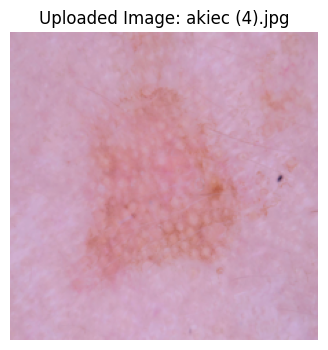

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 899ms/step

Prediction: df
Probabilities:
  akiec: 0.2411
  bcc: 0.2619
  bkl: 0.0956
  df: 0.2886
  nv: 0.0162
  vasc: 0.0748
  mel: 0.0219


In [67]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from PIL import Image
import matplotlib.pyplot as plt
from google.colab import files
import os


class_names = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc', 'mel']


try:

    val_unique = list(val_df_bal['dx'].unique())
    print("Unique class labels in val_df_bal:", val_unique)
except NameError:
    print("val_df_bal not found, proceeding with canonical class_names.")


try:
    model = load_model("custom_cnn_skin_model_v2.h5")
    print("Model loaded successfully.")


    output_shape = model.layers[-1].output.shape[1]
    print(f"Model output classes: {output_shape}")
    if output_shape != len(class_names):
        print(f"Warning: Model expects {output_shape} classes, but class_names has {len(class_names)} classes.")
except Exception as e:
    print(f"Failed to load model: {e}")
    raise


print("Please upload a test image (JPG/PNG, e.g., ISIC_0024306.jpg from HAM10000)")
uploaded = files.upload()

for filename in uploaded.keys():
    if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
        try:

            img = Image.open(filename)
            if img.mode != 'RGB':
                img = img.convert('RGB')
            img = img.resize((224, 224))
            img_array = img_to_array(img) / 255.0
            img_array = np.expand_dims(img_array, axis=0)


            plt.figure(figsize=(4,4))
            plt.imshow(img)
            plt.title(f"Uploaded Image: {filename}")
            plt.axis('off')
            plt.show()


            predictions = model.predict(img_array)
            predicted_index = np.argmax(predictions[0])


            if predicted_index >= len(class_names):
                raise IndexError(f"Predicted index {predicted_index} exceeds class_names length {len(class_names)}")

            predicted_class = class_names[predicted_index]

            probabilities = {class_names[i]: float(predictions[0][i]) for i in range(len(class_names))}

            print("\nPrediction:", predicted_class)
            print("Probabilities:")
            for label, prob in probabilities.items():
                print(f"  {label}: {prob:.4f}")

        except Exception as e:
            print(f"Error processing image {filename}: {e}")
        break
    else:
        print(f"Skipping {filename}: Not a JPG/PNG file")

Unique class labels in val_df_bal: ['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec']


Model loaded successfully.
Model output classes: 7
Please upload a test image (JPG/PNG, e.g., ISIC_0024306.jpg from HAM10000)


Saving vasc.jpg to vasc (4).jpg


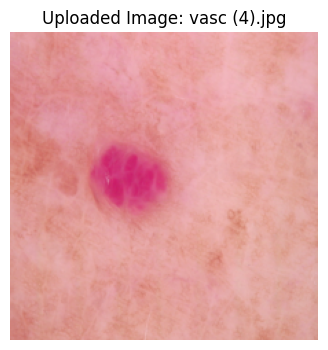

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step

Prediction: vasc
Probabilities:
  akiec: 0.0016
  bcc: 0.0057
  bkl: 0.0004
  df: 0.0016
  nv: 0.0016
  vasc: 0.9888
  mel: 0.0003


In [68]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from PIL import Image
import matplotlib.pyplot as plt
from google.colab import files
import os

class_names = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc', 'mel']

try:
    val_unique = list(val_df_bal['dx'].unique())
    print("Unique class labels in val_df_bal:", val_unique)
except NameError:
    print("val_df_bal not found, proceeding with canonical class_names.")

try:
    model = load_model("custom_cnn_skin_model_v2.h5")
    print("Model loaded successfully.")

    output_shape = model.layers[-1].output.shape[1]
    print(f"Model output classes: {output_shape}")
    if output_shape != len(class_names):
        print(f"Warning: Model expects {output_shape} classes, but class_names has {len(class_names)} classes.")
except Exception as e:
    print(f"Failed to load model: {e}")
    raise

print("Please upload a test image (JPG/PNG, e.g., ISIC_0024306.jpg from HAM10000)")
uploaded = files.upload()

for filename in uploaded.keys():
    if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
        try:
            img = Image.open(filename)
            if img.mode != 'RGB':
                img = img.convert('RGB')
            img = img.resize((224, 224))
            img_array = img_to_array(img) / 255.0
            img_array = np.expand_dims(img_array, axis=0)

            plt.figure(figsize=(4,4))
            plt.imshow(img)
            plt.title(f"Uploaded Image: {filename}")
            plt.axis('off')
            plt.show()

            predictions = model.predict(img_array)
            predicted_index = np.argmax(predictions[0])

            if predicted_index >= len(class_names):
                raise IndexError(f"Predicted index {predicted_index} exceeds class_names length {len(class_names)}")

            predicted_class = class_names[predicted_index]

            probabilities = {class_names[i]: float(predictions[0][i]) for i in range(len(class_names))}

            print("\nPrediction:", predicted_class)
            print("Probabilities:")
            for label, prob in probabilities.items():
                print(f"  {label}: {prob:.4f}")

        except Exception as e:
            print(f"Error processing image {filename}: {e}")
        break
    else:
        print(f"Skipping {filename}: Not a JPG/PNG file")

Unique class labels in val_df_bal: ['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec']


Model loaded successfully.
Model output classes: 7
Please upload a test image (JPG/PNG, e.g., ISIC_0024306.jpg from HAM10000)


Saving nv.jpg to nv (3).jpg


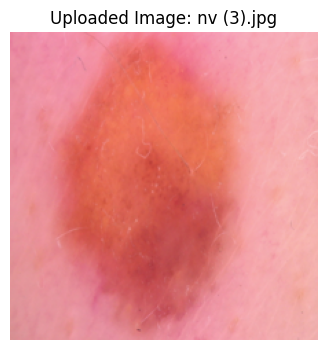

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 687ms/step

Prediction: nv
Probabilities:
  akiec: 0.0054
  bcc: 0.0005
  bkl: 0.0032
  df: 0.0009
  nv: 0.9831
  vasc: 0.0012
  mel: 0.0056


In [69]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from PIL import Image
import matplotlib.pyplot as plt
from google.colab import files
import os


class_names = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc', 'mel']


try:

    val_unique = list(val_df_bal['dx'].unique())
    print("Unique class labels in val_df_bal:", val_unique)
except NameError:
    print("val_df_bal not found, proceeding with canonical class_names.")


try:
    model = load_model("custom_cnn_skin_model_v2.h5")
    print("Model loaded successfully.")


    output_shape = model.layers[-1].output.shape[1]
    print(f"Model output classes: {output_shape}")
    if output_shape != len(class_names):
        print(f"Warning: Model expects {output_shape} classes, but class_names has {len(class_names)} classes.")
except Exception as e:
    print(f"Failed to load model: {e}")
    raise


print("Please upload a test image (JPG/PNG, e.g., ISIC_0024306.jpg from HAM10000)")
uploaded = files.upload()

for filename in uploaded.keys():
    if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
        try:

            img = Image.open(filename)
            if img.mode != 'RGB':
                img = img.convert('RGB')
            img = img.resize((224, 224))
            img_array = img_to_array(img) / 255.0
            img_array = np.expand_dims(img_array, axis=0)


            plt.figure(figsize=(4,4))
            plt.imshow(img)
            plt.title(f"Uploaded Image: {filename}")
            plt.axis('off')
            plt.show()


            predictions = model.predict(img_array)
            predicted_index = np.argmax(predictions[0])


            if predicted_index >= len(class_names):
                raise IndexError(f"Predicted index {predicted_index} exceeds class_names length {len(class_names)}")

            predicted_class = class_names[predicted_index]

            probabilities = {class_names[i]: float(predictions[0][i]) for i in range(len(class_names))}

            print("\nPrediction:", predicted_class)
            print("Probabilities:")
            for label, prob in probabilities.items():
                print(f"  {label}: {prob:.4f}")

        except Exception as e:
            print(f"Error processing image {filename}: {e}")
        break
    else:
        print(f"Skipping {filename}: Not a JPG/PNG file")

Unique class labels in val_df_bal: ['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec']


Model loaded successfully.
Model output classes: 7
Please upload a test image (JPG/PNG, e.g., ISIC_0024306.jpg from HAM10000)


Saving mel.jpg to mel (4).jpg


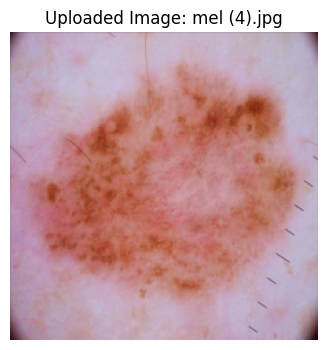

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step

Prediction: akiec
Probabilities:
  akiec: 0.2573
  bcc: 0.1133
  bkl: 0.1982
  df: 0.1040
  nv: 0.0774
  vasc: 0.0242
  mel: 0.2256


In [70]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from PIL import Image
import matplotlib.pyplot as plt
from google.colab import files
import os

# --- Step 1: Define canonical class names (must match training) ---
class_names = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc', 'mel']

# --- Step 2: Optionally, if val_df_bal exists, verify classes ---
try:
    # If val_df_bal is loaded, check its unique labels for info only
    val_unique = list(val_df_bal['dx'].unique())
    print("Unique class labels in val_df_bal:", val_unique)
except NameError:
    print("val_df_bal not found, proceeding with canonical class_names.")

# --- Step 3: Load the model ---
try:
    model = load_model("custom_cnn_skin_model_v2.h5")
    print("Model loaded successfully.")

    # Verify output layer shape matches class_names length
    output_shape = model.layers[-1].output.shape[1]
    print(f"Model output classes: {output_shape}")
    if output_shape != len(class_names):
        print(f"Warning: Model expects {output_shape} classes, but class_names has {len(class_names)} classes.")
except Exception as e:
    print(f"Failed to load model: {e}")
    raise

# --- Step 4: Upload and preprocess test image ---
print("Please upload a test image (JPG/PNG, e.g., ISIC_0024306.jpg from HAM10000)")
uploaded = files.upload()

for filename in uploaded.keys():
    if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
        try:
            # Load image and preprocess
            img = Image.open(filename)
            if img.mode != 'RGB':
                img = img.convert('RGB')
            img = img.resize((224, 224))  # Same as training IMG_SIZE
            img_array = img_to_array(img) / 255.0  # Normalize
            img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

            # Show the image
            plt.figure(figsize=(4,4))
            plt.imshow(img)
            plt.title(f"Uploaded Image: {filename}")
            plt.axis('off')
            plt.show()

            # Predict
            predictions = model.predict(img_array)
            predicted_index = np.argmax(predictions[0])

            # Sanity check index
            if predicted_index >= len(class_names):
                raise IndexError(f"Predicted index {predicted_index} exceeds class_names length {len(class_names)}")

            predicted_class = class_names[predicted_index]

            # Build probabilities dict
            probabilities = {class_names[i]: float(predictions[0][i]) for i in range(len(class_names))}

            print("\nPrediction:", predicted_class)
            print("Probabilities:")
            for label, prob in probabilities.items():
                print(f"  {label}: {prob:.4f}")

        except Exception as e:
            print(f"Error processing image {filename}: {e}")
        break
    else:
        print(f"Skipping {filename}: Not a JPG/PNG file")


Unique class labels in val_df_bal: ['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec']


Model loaded successfully.
Model output classes: 7
Please upload a test image (JPG/PNG, e.g., ISIC_0024306.jpg from HAM10000)


Saving df.jpg to df (4).jpg


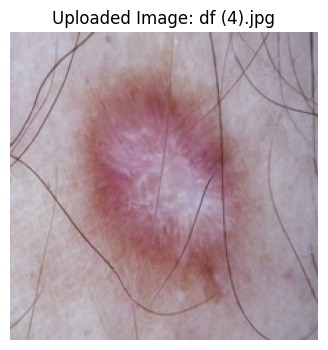

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step

Prediction: akiec
Probabilities:
  akiec: 0.2530
  bcc: 0.2507
  bkl: 0.1702
  df: 0.1944
  nv: 0.0251
  vasc: 0.0477
  mel: 0.0589


In [71]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from PIL import Image
import matplotlib.pyplot as plt
from google.colab import files
import os

class_names = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc', 'mel']

try:
    val_unique = list(val_df_bal['dx'].unique())
    print("Unique class labels in val_df_bal:", val_unique)
except NameError:
    print("val_df_bal not found, proceeding with canonical class_names.")

try:
    model = load_model("custom_cnn_skin_model_v2.h5")
    print("Model loaded successfully.")

    output_shape = model.layers[-1].output.shape[1]
    print(f"Model output classes: {output_shape}")
    if output_shape != len(class_names):
        print(f"Warning: Model expects {output_shape} classes, but class_names has {len(class_names)} classes.")
except Exception as e:
    print(f"Failed to load model: {e}")
    raise

print("Please upload a test image (JPG/PNG, e.g., ISIC_0024306.jpg from HAM10000)")
uploaded = files.upload()

for filename in uploaded.keys():
    if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
        try:
            img = Image.open(filename)
            if img.mode != 'RGB':
                img = img.convert('RGB')
            img = img.resize((224, 224))
            img_array = img_to_array(img) / 255.0
            img_array = np.expand_dims(img_array, axis=0)

            plt.figure(figsize=(4,4))
            plt.imshow(img)
            plt.title(f"Uploaded Image: {filename}")
            plt.axis('off')
            plt.show()

            predictions = model.predict(img_array)
            predicted_index = np.argmax(predictions[0])

            if predicted_index >= len(class_names):
                raise IndexError(f"Predicted index {predicted_index} exceeds class_names length {len(class_names)}")

            predicted_class = class_names[predicted_index]

            probabilities = {class_names[i]: float(predictions[0][i]) for i in range(len(class_names))}

            print("\nPrediction:", predicted_class)
            print("Probabilities:")
            for label, prob in probabilities.items():
                print(f"  {label}: {prob:.4f}")

        except Exception as e:
            print(f"Error processing image {filename}: {e}")
        break
    else:
        print(f"Skipping {filename}: Not a JPG/PNG file")

Unique class labels in val_df_bal: ['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec']


Model loaded successfully.
Model output classes: 7
Please upload a test image (JPG/PNG, e.g., ISIC_0024306.jpg from HAM10000)


Saving bkl.jpg to bkl (5).jpg


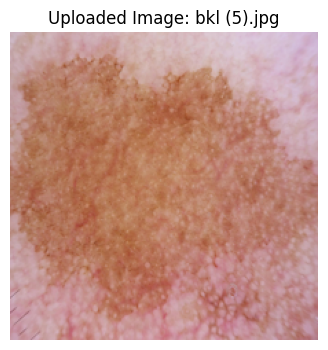

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step

Prediction: bkl
Probabilities:
  akiec: 0.2300
  bcc: 0.1467
  bkl: 0.2354
  df: 0.1279
  nv: 0.0635
  vasc: 0.0168
  mel: 0.1798


In [72]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from PIL import Image
import matplotlib.pyplot as plt
from google.colab import files
import os


class_names = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc', 'mel']


try:

    val_unique = list(val_df_bal['dx'].unique())
    print("Unique class labels in val_df_bal:", val_unique)
except NameError:
    print("val_df_bal not found, proceeding with canonical class_names.")


try:
    model = load_model("custom_cnn_skin_model_v2.h5")
    print("Model loaded successfully.")


    output_shape = model.layers[-1].output.shape[1]
    print(f"Model output classes: {output_shape}")
    if output_shape != len(class_names):
        print(f"Warning: Model expects {output_shape} classes, but class_names has {len(class_names)} classes.")
except Exception as e:
    print(f"Failed to load model: {e}")
    raise


print("Please upload a test image (JPG/PNG, e.g., ISIC_0024306.jpg from HAM10000)")
uploaded = files.upload()

for filename in uploaded.keys():
    if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
        try:

            img = Image.open(filename)
            if img.mode != 'RGB':
                img = img.convert('RGB')
            img = img.resize((224, 224))
            img_array = img_to_array(img) / 255.0
            img_array = np.expand_dims(img_array, axis=0)


            plt.figure(figsize=(4,4))
            plt.imshow(img)
            plt.title(f"Uploaded Image: {filename}")
            plt.axis('off')
            plt.show()


            predictions = model.predict(img_array)
            predicted_index = np.argmax(predictions[0])


            if predicted_index >= len(class_names):
                raise IndexError(f"Predicted index {predicted_index} exceeds class_names length {len(class_names)}")

            predicted_class = class_names[predicted_index]

            probabilities = {class_names[i]: float(predictions[0][i]) for i in range(len(class_names))}

            print("\nPrediction:", predicted_class)
            print("Probabilities:")
            for label, prob in probabilities.items():
                print(f"  {label}: {prob:.4f}")

        except Exception as e:
            print(f"Error processing image {filename}: {e}")
        break
    else:
        print(f"Skipping {filename}: Not a JPG/PNG file")

Unique class labels in val_df_bal: ['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec']


Model loaded successfully.
Model output classes: 7
Please upload a test image (JPG/PNG, e.g., ISIC_0024306.jpg from HAM10000)


Saving bcc.jpg to bcc (4).jpg


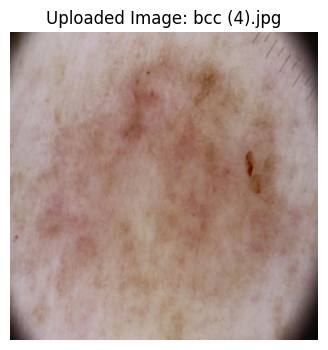

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step

Prediction: akiec
Probabilities:
  akiec: 0.2768
  bcc: 0.1844
  bkl: 0.2029
  df: 0.1456
  nv: 0.0490
  vasc: 0.0344
  mel: 0.1068


In [73]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from PIL import Image
import matplotlib.pyplot as plt
from google.colab import files
import os


class_names = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc', 'mel']


try:

    val_unique = list(val_df_bal['dx'].unique())
    print("Unique class labels in val_df_bal:", val_unique)
except NameError:
    print("val_df_bal not found, proceeding with canonical class_names.")


try:
    model = load_model("custom_cnn_skin_model_v2.h5")
    print("Model loaded successfully.")


    output_shape = model.layers[-1].output.shape[1]
    print(f"Model output classes: {output_shape}")
    if output_shape != len(class_names):
        print(f"Warning: Model expects {output_shape} classes, but class_names has {len(class_names)} classes.")
except Exception as e:
    print(f"Failed to load model: {e}")
    raise


print("Please upload a test image (JPG/PNG, e.g., ISIC_0024306.jpg from HAM10000)")
uploaded = files.upload()

for filename in uploaded.keys():
    if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
        try:

            img = Image.open(filename)
            if img.mode != 'RGB':
                img = img.convert('RGB')
            img = img.resize((224, 224))
            img_array = img_to_array(img) / 255.0
            img_array = np.expand_dims(img_array, axis=0)


            plt.figure(figsize=(4,4))
            plt.imshow(img)
            plt.title(f"Uploaded Image: {filename}")
            plt.axis('off')
            plt.show()


            predictions = model.predict(img_array)
            predicted_index = np.argmax(predictions[0])


            if predicted_index >= len(class_names):
                raise IndexError(f"Predicted index {predicted_index} exceeds class_names length {len(class_names)}")

            predicted_class = class_names[predicted_index]

            probabilities = {class_names[i]: float(predictions[0][i]) for i in range(len(class_names))}

            print("\nPrediction:", predicted_class)
            print("Probabilities:")
            for label, prob in probabilities.items():
                print(f"  {label}: {prob:.4f}")

        except Exception as e:
            print(f"Error processing image {filename}: {e}")
        break
    else:
        print(f"Skipping {filename}: Not a JPG/PNG file")


In [79]:
import tensorflow as tf

model = tf.keras.models.load_model("custom_cnn_skin_model_v2.h5")

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

with open("quantized_model.tflite", "wb") as f:
    f.write(tflite_model)

print("Quantized model saved as quantized_model.tflite")


Saved artifact at '/tmp/tmp2ktq5kro'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_7')
Output Type:
  TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)
Captures:
  138700249463696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138700249449872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138700249464272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138700249461008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138700249460240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138700249461392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138694865593424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138694865587664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138700016429264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138700249457936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1387002494525